# Определение перспективного тарифа для телеком-компании


### Описание проекта


Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

### Описание тарифов

#### Тариф «Смарт»

1. Ежемесячная плата: 550 рублей
2. Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета:
    - минута разговора: 3 рубля
    - сообщение: 3 рубля
    - 1 Гб интернет-трафика: 200 рублей
    
### Тариф «Ультра»
1. Ежемесячная плата: 1950 рублей
2. Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета:
    - минута разговора: 1 рубль
    - сообщение: 1 рубль
    - 1 Гб интернет-трафика: 150 рублей
    
    
__Примечание:__

`
«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.
Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта. Примите, что неиспользованные за предыдущий месяц звонки, смс, интернет на следующий месяц не переносятся.
`




In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

## Подготовка данных

In [2]:
users_df = pd.read_csv('/datasets/users.csv')
calls_df = pd.read_csv('/datasets/calls.csv')
messages_df = pd.read_csv('/datasets/messages.csv')
internet_df = pd.read_csv('/datasets/internet.csv')
tariffs_df = pd.read_csv('/datasets/tariffs.csv')

Напишем функцию для выдачи стандартной инфорамции о датасете

In [3]:
def describe_dataset(data: pd.DataFrame):
    print(data.info())
    print('\n')
    print(data.describe())
    print('\n')

    print('Количество дубликатов: ', data.duplicated().sum())
    print('\n')

    data.head()

### Таблица users (информация о пользователях):
- user_id — уникальный идентификатор пользователя
- first_name — имя пользователя
- last_name — фамилия пользователя
- age — возраст пользователя (годы)
- reg_date — дата подключения тарифа (день, месяц, год)
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- city — город проживания пользователя
- tariff — название тарифного плана

In [4]:
describe_dataset(users_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
None


           user_id        age
count   500.000000  500.00000
mean   1249.500000   46.58800
std     144.481833   16.66763
min    1000.000000   18.00000
25%    1124.750000   32.00000
50%    1249.500000   46.00000
75%    1374.250000   62.00000
max    1499.000000   75.00000


Количество дубликатов:  0




In [5]:
users_df.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [6]:
# Поправим формат дат
users_df['reg_date'] = pd.to_datetime(users_df['reg_date'], format='%Y-%m-%d')

In [7]:
# проверим что с названиями городов все хорошо
users_df['city'].unique()

array(['Краснодар', 'Москва', 'Стерлитамак', 'Новокузнецк',
       'Набережные Челны', 'Ульяновск', 'Челябинск', 'Пермь', 'Тюмень',
       'Самара', 'Санкт-Петербург', 'Иваново', 'Чебоксары', 'Омск', 'Уфа',
       'Томск', 'Чита', 'Мурманск', 'Петрозаводск', 'Тверь',
       'Екатеринбург', 'Махачкала', 'Вологда', 'Череповец', 'Ярославль',
       'Сочи', 'Хабаровск', 'Ставрополь', 'Рязань', 'Улан-Удэ', 'Тула',
       'Саратов', 'Ростов-на-Дону', 'Казань', 'Иркутск', 'Курск',
       'Калуга', 'Якутск', 'Астрахань', 'Химки', 'Владикавказ',
       'Волгоград', 'Саранск', 'Ижевск', 'Новосибирск', 'Брянск',
       'Тольятти', 'Нижний Тагил', 'Орёл', 'Белгород', 'Воронеж',
       'Волжский', 'Курган', 'Барнаул', 'Красноярск', 'Архангельск',
       'Липецк', 'Кемерово', 'Киров', 'Сургут', 'Пенза', 'Магнитогорск',
       'Нижний Новгород', 'Кострома', 'Владивосток', 'Тамбов', 'Балашиха',
       'Севастополь', 'Калининград', 'Оренбург', 'Смоленск',
       'Нижневартовск', 'Владимир', 'Новороссий

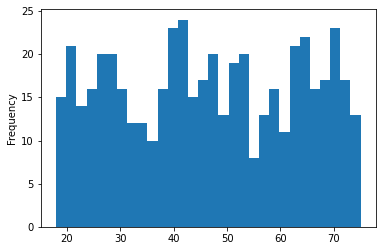

In [8]:
users_df['age'].plot(kind='hist', bins=30)
plt.show()

### Таблица calls (информация о звонках):
- id — уникальный номер звонка
- call_date — дата звонка
- duration — длительность звонка в минутах
- user_id — идентификатор пользователя, сделавшего звонок

In [9]:
describe_dataset(calls_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
None


            duration        user_id
count  202607.000000  202607.000000
mean        6.755887    1253.940619
std         5.843365     144.722751
min         0.000000    1000.000000
25%         1.300000    1126.000000
50%         6.000000    1260.000000
75%        10.700000    1379.000000
max        38.000000    1499.000000


Количество дубликатов:  0




In [10]:
calls_df.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [11]:
# Поправим формат дат
calls_df['call_date'] = pd.to_datetime(calls_df['call_date'], format='%Y-%m-%d')

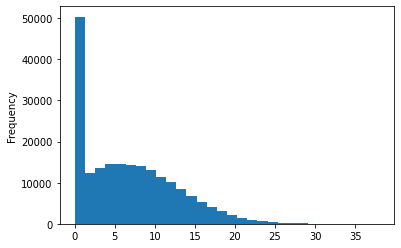

In [12]:
calls_df['duration'].plot(kind='hist', bins=30)
plt.show()

Округлим время звонка вверх, согласно тарифу

In [13]:
calls_df['duration'] = np.ceil(calls_df['duration']).astype('int')

### Таблица messages (информация о сообщениях):
- id — уникальный номер сообщения
- message_date — дата сообщения
- user_id — идентификатор пользователя, отправившего сообщение

In [14]:
describe_dataset(messages_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB
None


             user_id
count  123036.000000
mean     1256.989410
std       143.523967
min      1000.000000
25%      1134.000000
50%      1271.000000
75%      1381.000000
max      1499.000000


Количество дубликатов:  0




In [15]:
messages_df.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [16]:
# Поправим формат дат
messages_df['message_date'] = pd.to_datetime(messages_df['message_date'], format='%Y-%m-%d')

### Таблица internet (информация об интернет-сессиях):
- id — уникальный номер сессии
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
- session_date — дата интернет-сессии
- user_id — идентификатор пользователя

In [17]:
describe_dataset(internet_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB
None


          Unnamed: 0        mb_used        user_id
count  149396.000000  149396.000000  149396.000000
mean    74697.500000     370.192426    1252.099842
std     43127.054745     278.300951     144.050823
min         0.000000       0.000000    1000.000000
25%     37348.750000     138.187500    1130.000000
50%     74697.500000     348.015000    1251.000000
75%    112046.250000     559.552500    1380.000000
max    149395.000000    1724.830000    1499.000000


Количество дубликатов:  0




In [18]:
internet_df.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


Cкорее всего, этот датасет был записан с опцией pd.to_csv('file.csv', index=True), а не False. Никто не идеален, просто удалим столбец


In [19]:
internet_df.drop('Unnamed: 0', axis=1, inplace=True)

In [20]:
# Поправим формат дат
internet_df['session_date'] = pd.to_datetime(internet_df['session_date'], format='%Y-%m-%d')

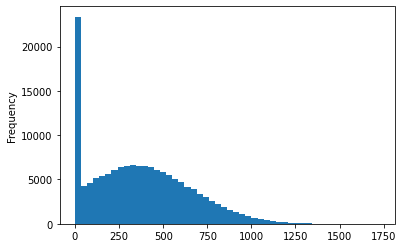

In [21]:
internet_df['mb_used'].plot(kind='hist', bins=50)
plt.show()

Выглядит неплохо, очевидных ошибок нет

### Таблица tariffs (информация о тарифах):
- tariff_name — название тарифа
- rub_monthly_fee — ежемесячная абонентская плата в рублях
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
- messages_included — количество сообщений в месяц, включённых в абонентскую плату
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

In [23]:
describe_dataset(tariffs_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes
None


       messages_included  mb_per_month_included  minutes_included  \
count           2.000000               2.000000          2.000000   
mean          525.000000           23040.000000       1750.000000   
std           671.751442           10861.160159       1767.766953   
min            50.000000           15360.000000     

In [24]:
tariffs_df.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


# Шаг 2. Подготовьте данные

Посчитайте для каждого пользователя:
- количество сделанных звонков и израсходованных минут разговора по месяцам;
- количество отправленных сообщений по месяцам;
- объем израсходованного интернет-трафика по месяцам;
- помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).

In [25]:
internet = internet_df.groupby(['user_id', internet_df.session_date.dt.month])\
                            .agg({'mb_used':'sum'})\
                            .reset_index()\
                            .rename(columns={'mb_used': 'total_mb_in_month',
                                            'session_date': 'month'}
                            )

In [26]:
internet.head()

,user_id,month,total_mb_in_month
0,1000,5,2253.49
1,1000,6,23233.77
2,1000,7,14003.64
3,1000,8,14055.93
4,1000,9,14568.91


In [27]:
calls = calls_df.groupby(['user_id', calls_df.call_date.dt.month])\
                .agg({'duration':'sum', 'id':'count'})\
                .reset_index()\
                .rename(columns={'duration': 'total_minutes_in_month', 
                                 'id':'total_count_call_in_mounth',
                                 'call_date': 'month'
                                }
                       )


In [28]:
calls.head()

,user_id,month,total_minutes_in_month,total_count_call_in_mounth
0,1000,5,159,22
1,1000,6,172,43
2,1000,7,340,47
3,1000,8,408,52
4,1000,9,466,58


In [29]:
messages = messages_df.groupby(['user_id', messages_df.message_date.dt.month])\
                .agg({'id':'count'})\
                .reset_index()\
                .rename(columns={'id': 'total_messages_in_month',
                                 'message_date':'month'
                                })

In [30]:
messages.head()

,user_id,month,total_messages_in_month
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57


Склеим все вместе

In [31]:
revenue = calls.merge(messages, on=['user_id','month'], how='outer')
revenue = revenue.merge(internet, on=['user_id','month'], how='outer')
revenue.head()

,user_id,month,total_minutes_in_month,total_count_call_in_mounth,total_messages_in_month,total_mb_in_month
0,1000,5,159.0,22.0,22.0,2253.49
1,1000,6,172.0,43.0,60.0,23233.77
2,1000,7,340.0,47.0,75.0,14003.64
3,1000,8,408.0,52.0,81.0,14055.93
4,1000,9,466.0,58.0,57.0,14568.91


Добавим информацию о тарифах

In [32]:
tariff = users_df.merge(tariffs_df, left_on='tariff', right_on='tariff_name', how='left')
tariff.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart,50,15360,500,550,200,3,3,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,50,15360,500,550,200,3,3,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra,1000,30720,3000,1950,150,1,1,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra,1000,30720,3000,1950,150,1,1,ultra


Не будем тащить в таблицу `revenue` все подряд, выберем только нужные для работы столбцы

In [33]:
useful_tariff_columns = ['user_id','messages_included', 'mb_per_month_included',
       'minutes_included', 'rub_monthly_fee', 'rub_per_gb', 'rub_per_message',
       'rub_per_minute','city','tariff']

In [34]:
revenue = revenue.merge(tariff[useful_tariff_columns], on=['user_id'], how='left')

In [35]:
revenue.head(20)

,user_id,month,total_minutes_in_month,total_count_call_in_mounth,total_messages_in_month,total_mb_in_month,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,city,tariff
0,1000,5,159.0,22.0,22.0,2253.49,1000,30720,3000,1950,150,1,1,Краснодар,ultra
1,1000,6,172.0,43.0,60.0,23233.77,1000,30720,3000,1950,150,1,1,Краснодар,ultra
2,1000,7,340.0,47.0,75.0,14003.64,1000,30720,3000,1950,150,1,1,Краснодар,ultra
3,1000,8,408.0,52.0,81.0,14055.93,1000,30720,3000,1950,150,1,1,Краснодар,ultra
4,1000,9,466.0,58.0,57.0,14568.91,1000,30720,3000,1950,150,1,1,Краснодар,ultra
5,1000,10,350.0,57.0,73.0,14702.49,1000,30720,3000,1950,150,1,1,Краснодар,ultra
6,1000,11,338.0,43.0,58.0,14756.47,1000,30720,3000,1950,150,1,1,Краснодар,ultra
7,1000,12,333.0,46.0,70.0,9817.61,1000,30720,3000,1950,150,1,1,Краснодар,ultra
8,1001,11,430.0,59.0,NaN,18429.34,50,15360,500,550,200,3,3,Москва,smart
9,1001,12,414.0,63.0,NaN,14036.66,50,15360,500,550,200,3,3,Москва,smart


In [36]:
revenue.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   user_id                     3214 non-null   int64  
 1   month                       3214 non-null   int64  
 2   total_minutes_in_month      3174 non-null   float64
 3   total_count_call_in_mounth  3174 non-null   float64
 4   total_messages_in_month     2717 non-null   float64
 5   total_mb_in_month           3203 non-null   float64
 6   messages_included           3214 non-null   int64  
 7   mb_per_month_included       3214 non-null   int64  
 8   minutes_included            3214 non-null   int64  
 9   rub_monthly_fee             3214 non-null   int64  
 10  rub_per_gb                  3214 non-null   int64  
 11  rub_per_message             3214 non-null   int64  
 12  rub_per_minute              3214 non-null   int64  
 13  city                        3214 

У нас есть пользователи, которые не пользуются некоторыми из услуг. Заполним для них пропуски нулями

In [37]:
revenue['total_minutes_in_month'] = revenue['total_minutes_in_month'].fillna(0)
revenue['total_count_call_in_mounth'] = revenue['total_count_call_in_mounth'].fillna(0)
revenue['total_messages_in_month'] = revenue['total_messages_in_month'].fillna(0)
revenue['total_mb_in_month'] = revenue['total_mb_in_month'].fillna(0)

In [38]:
revenue.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   user_id                     3214 non-null   int64  
 1   month                       3214 non-null   int64  
 2   total_minutes_in_month      3214 non-null   float64
 3   total_count_call_in_mounth  3214 non-null   float64
 4   total_messages_in_month     3214 non-null   float64
 5   total_mb_in_month           3214 non-null   float64
 6   messages_included           3214 non-null   int64  
 7   mb_per_month_included       3214 non-null   int64  
 8   minutes_included            3214 non-null   int64  
 9   rub_monthly_fee             3214 non-null   int64  
 10  rub_per_gb                  3214 non-null   int64  
 11  rub_per_message             3214 non-null   int64  
 12  rub_per_minute              3214 non-null   int64  
 13  city                        3214 

Все хорошо, подсчитаем прибыль

In [39]:
def calculate_revenue(row):
    message_revenue = (row['total_messages_in_month'] - row['messages_included']) * row['rub_per_message']
    call_revenue = (row['total_minutes_in_month'] - row['minutes_included']) * row['rub_per_minute']
    trafffic_revenue = np.ceil((row['total_mb_in_month'] - row['mb_per_month_included']) / 1024) * row['rub_per_gb']
    
    excess_revenue = 0
    for item in [message_revenue, call_revenue, trafffic_revenue]:
        if item > 0:
            excess_revenue += item
    return excess_revenue

In [40]:
revenue['excess_revenue'] = revenue.apply(calculate_revenue, axis=1)

In [41]:
revenue['total_revenue'] = revenue['excess_revenue'] + revenue['rub_monthly_fee']

In [42]:
revenue.head(20)

,user_id,month,total_minutes_in_month,total_count_call_in_mounth,total_messages_in_month,total_mb_in_month,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,city,tariff,excess_revenue,total_revenue
0,1000,5,159.0,22.0,22.0,2253.49,1000,30720,3000,1950,150,1,1,Краснодар,ultra,0.0,1950.0
1,1000,6,172.0,43.0,60.0,23233.77,1000,30720,3000,1950,150,1,1,Краснодар,ultra,0.0,1950.0
2,1000,7,340.0,47.0,75.0,14003.64,1000,30720,3000,1950,150,1,1,Краснодар,ultra,0.0,1950.0
3,1000,8,408.0,52.0,81.0,14055.93,1000,30720,3000,1950,150,1,1,Краснодар,ultra,0.0,1950.0
4,1000,9,466.0,58.0,57.0,14568.91,1000,30720,3000,1950,150,1,1,Краснодар,ultra,0.0,1950.0
5,1000,10,350.0,57.0,73.0,14702.49,1000,30720,3000,1950,150,1,1,Краснодар,ultra,0.0,1950.0
6,1000,11,338.0,43.0,58.0,14756.47,1000,30720,3000,1950,150,1,1,Краснодар,ultra,0.0,1950.0
7,1000,12,333.0,46.0,70.0,9817.61,1000,30720,3000,1950,150,1,1,Краснодар,ultra,0.0,1950.0
8,1001,11,430.0,59.0,0.0,18429.34,50,15360,500,550,200,3,3,Москва,smart,600.0,1150.0
9,1001,12,414.0,63.0,0.0,14036.66,50,15360,500,550,200,3,3,Москва,smart,0.0,550.0


У нас есть таблица с месячной выручкой по клиентам. Ура

## Проанализируем данные


Опишите поведение клиентов оператора, исходя из выборки. 
-  Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? 
- Посчитайте среднее количество, дисперсию и стандартное отклонение. 
- Постройте гистограммы. 
- Опишите распределения.

### Сколько минут разговора требуется пользователям каждого тарифа в месяц?

In [43]:
df_calls_smart = revenue[revenue['tariff'] == 'smart']['total_minutes_in_month']
df_calls_ultra = revenue[revenue['tariff'] == 'ultra']['total_minutes_in_month']

In [44]:
df_calls_smart.describe()

count    2229.000000
mean      417.934948
std       190.313730
min         0.000000
25%       282.000000
50%       422.000000
75%       545.000000
max      1435.000000
Name: total_minutes_in_month, dtype: float64

In [45]:
df_calls_ultra.describe()

count     985.000000
mean      526.623350
std       317.606098
min         0.000000
25%       284.000000
50%       518.000000
75%       752.000000
max      1673.000000
Name: total_minutes_in_month, dtype: float64

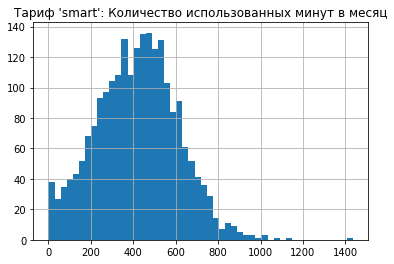

In [46]:
df_calls_smart.hist(bins=50)
plt.title("Тариф 'smart': Количество использованных минут в месяц")
plt.show()

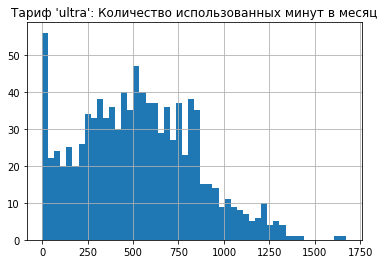

In [47]:
df_calls_ultra.hist(bins=50)
plt.title("Тариф 'ultra': Количество использованных минут в месяц")
plt.show()

In [48]:
tariffs_df[['tariff_name', 'minutes_included']]

,tariff_name,minutes_included
0,smart,500
1,ultra,3000


Можем увидеть, что для тарифа `ultra` почти все пользователи укладываются в тариф. Для тарифа `smart` за  ограничения выходят около половины пользователей.

### Сколько трафика требуется пользователям каждого тарифа в месяц?

In [49]:
df_traffic_smart = revenue[revenue['tariff'] == 'smart']['total_mb_in_month']
df_traffic_ultra = revenue[revenue['tariff'] == 'ultra']['total_mb_in_month']

In [50]:
df_traffic_smart.describe()

count     2229.000000
mean     16208.386990
std       5870.476681
min          0.000000
25%      12643.010000
50%      16506.840000
75%      20042.930000
max      38552.450000
Name: total_mb_in_month, dtype: float64

In [51]:
df_traffic_ultra.describe()

count      985.000000
mean     19468.805208
std      10087.170752
min          0.000000
25%      11770.260000
50%      19308.010000
75%      26837.690000
max      49745.690000
Name: total_mb_in_month, dtype: float64

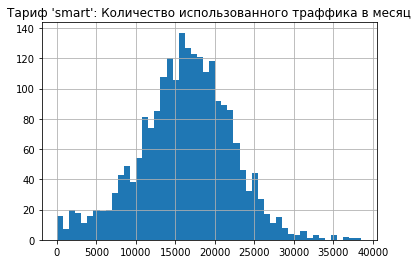

In [52]:
df_traffic_smart.hist(bins=50)
plt.title("Тариф 'smart': Количество использованного траффика в месяц")
plt.show()

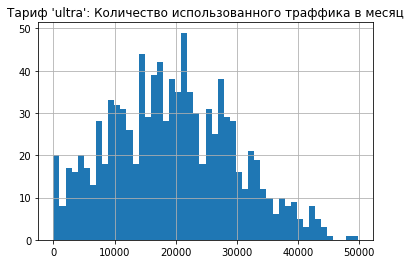

In [53]:
df_traffic_ultra.hist(bins=50)
plt.title("Тариф 'ultra': Количество использованного траффика в месяц")
plt.show()

In [54]:
tariffs_df[['tariff_name', 'mb_per_month_included']]

,tariff_name,mb_per_month_included
0,smart,15360
1,ultra,30720


Можем увидеть, что для тарифа `ultra` 3/4 пользователей, укладывается в тариф. Для тарифа `smart` за  ограничения выходят опять же чуть больше половины пользователей.

### Сколько sms требуется пользователям каждого тарифа в месяц?

In [55]:
df_message_smart = revenue[revenue['tariff'] == 'smart']['total_messages_in_month']
df_message_ultra = revenue[revenue['tariff'] == 'ultra']['total_messages_in_month']

In [56]:
df_message_smart.describe()

count    2229.000000
mean       33.384029
std        28.227876
min         0.000000
25%        10.000000
50%        28.000000
75%        51.000000
max       143.000000
Name: total_messages_in_month, dtype: float64

In [57]:
df_message_ultra.describe()

count    985.000000
mean      49.363452
std       47.804457
min        0.000000
25%        6.000000
50%       38.000000
75%       79.000000
max      224.000000
Name: total_messages_in_month, dtype: float64

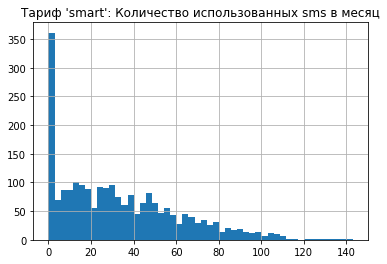

In [58]:
df_message_smart.hist(bins=50)
plt.title("Тариф 'smart': Количество использованных sms в месяц")
plt.show()

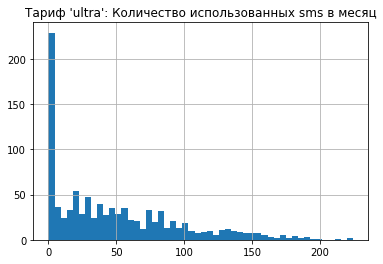

In [59]:
df_message_ultra.hist(bins=50)
plt.title("Тариф 'ultra': Количество использованных sms в месяц")
plt.show()

In [60]:
tariffs_df[['tariff_name', 'messages_included']]

,tariff_name,messages_included
0,smart,50
1,ultra,1000


Можем увидеть, что для тарифа `smart` большинство пользователей, укладывается в тариф. Для тарифа `ultra` за  ограничения не выходит никто. Вообще и та и та категории очень похожи по характеру использования сообщений. 

### Вывод

Можно сказать что 3/4 пользователей тарифа `ultra` укладывается в тариф. Пользователи тарифа `smart` выходят за ограничения постоянно. Распределения по параметрам `Количество использованного траффика в месяц` и `Количество использованных минут в месяц`  носят нормальный хараетер.

Параметр `Количество использованных sms в месяц` имеет специфическое рапределение, что по-видимому связанно с тем, что необходимость в sms постепенно исчезает

In [61]:
# код ревьюера
revenue.pivot_table(index = 'tariff', values = ['total_minutes_in_month', 'total_messages_in_month', 'total_messages_in_month'],
                aggfunc = ['mean', 'std', 'var'])

mean                                                 \
       total_messages_in_month total_messages_in_month total_minutes_in_month   
tariff                                                                          
smart                33.384029               33.384029             417.934948   
ultra                49.363452               49.363452             526.623350   

                           std                                                 \
       total_messages_in_month total_messages_in_month total_minutes_in_month   
tariff                                                                          
smart                28.227876               28.227876             190.313730   
ultra                47.804457               47.804457             317.606098   

                           var                                                 
       total_messages_in_month total_messages_in_month total_minutes_in_month  
tariff                                                                         
smart               796.812958              796.812958           36219.315784  
ultra              2285.266143             2285.266143          100873.633397

## Проверка гипотез

- средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
- средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Пороговое значение alpha задайте самостоятельно.
Поясните:
- как вы формулировали нулевую и альтернативную гипотезы;
- какой критерий использовали для проверки гипотез и почему.

Посмотрим на объем выборок, с которыми мы будем работать

In [62]:
revenue['tariff'].value_counts()

smart    2229
ultra     985
Name: tariff, dtype: int64

И там и там количество значений больше 50, следовательно выборочное среднее распределено нормально.
Используем t-критерий Стьюдента.

### Гипотеза о равенстве выручки на тарифах «Ультра» и «Смарт»


У нас есть метод st.ttest_ind, который проверяет гипотезу о равенстве среднего двух генеральных совокупностей по взятым из них выборкам - будем строить гипотезы соответственно.

Сформулируем гипотезы:

- H0: выручка пользователей тарифов «Ультра» и «Смарт» не различается
- H1: выручка пользователей тарифов «Ультра» и «Смарт» различается

Выберем p-value = 0.05

In [63]:
quantile_0005 = revenue['total_revenue'].quantile(0.005)
quantile_0995 = revenue['total_revenue'].quantile(0.995)

Удалим то, что лежит за 99%

In [64]:
mask = (revenue.total_revenue > quantile_0005)&(revenue.total_revenue < quantile_0995)

In [65]:
revenue_ultra = revenue[mask & (revenue.tariff =='ultra')]['total_revenue']
revenue_smart = revenue[mask & (revenue.tariff =='smart')]['total_revenue']

In [66]:
results = st.ttest_ind(revenue_ultra, revenue_smart)
print('p-значение: ', results.pvalue)

p-значение:  1.3290107037532163e-99


Отвергаем нулевую гипотезу.

Видим, что выручка по тарифам статистически различается

### Гипотеза о равенстве выручки в Москве и в регионах

Сформулируем гипотезы:

- H0: средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов.
- H1: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Выберем p-value = 0.05

In [67]:
revenue_moscow = revenue[mask & (revenue.city =='Москва')]['total_revenue']
revenue_russia = revenue[mask & (revenue.city !='Москва')]['total_revenue']

In [68]:
results = st.ttest_ind(revenue_moscow, revenue_russia)
print('p-значение: ', results.pvalue)

p-значение:  0.22001861114582444


Не получилось отвергнуть нулевую гипотезу. 

Между выручкой в Москве и в регионах нет статистически достоверных различий.

## Общий вывод

Поведение пользователей на обоих тарифах различается по объему использованного трафика и использованных минут разговора, и что самое главное - по объему выручки от этих тарифов. 

Пользователи тарифа `Ультра` по большей части не превышают ограничений тарифа, в то время как пользователям тарифа `Смарт` не хватает и трафика и минут разговора, им приходится докупать и то и другое. 

Сообщения практически одинаково используются пользователями обоих тарифов. 

Между выручкой в Москве и в регионах нет существенных различий.


### Рекомендации:

Очевидны проблемы  с сегментацией - пользователей тарифа `Смарт` необходимо разделить на две категории - они массово не помещаются в текущие ограничения.

Округление трафика по гигабайту выглядит дико с учетом среднего количества трафика - пользователям тарифа `Смарт` придется существенно доплачивать из-за округления вверх, что может привести к их недовольству.

Количество sms необходимо уменьшить у тарифа `Ультра` - наблюдается большой разрыв между реальным потреблением и количеством sms в пакете.